# Train your first computer vision model
### How to use data augmentation and convolutional neural networks to train a face recognition system

## Problem statement

We all know that feeling... 

> You arrive at a conference / workshop and you have a hard time remembering names. 

![Typical CNN](https://imgs.xkcd.com/comics/names.png)

## Solution

As Data Scientists we want a solution, hands on!

We implement a face recognition app called **WhoRU** that runs on your smartphone and recognises previously tagged participants.

## Step by step

1. You  took pictures of all participants with the **WhoRU** app from your mobile phone and assigned the correct name to them (__data collection & labelling__)

2. Here you will train a deep learning model (based on convolutional networks) to recognise and correctly label the participants (__data preparation & training__)

3. You can try your model in the "Predict"-mode of **WhoRU** and apply it to new photos taken (__generalisation & evaluation__)

4. Have fun networking...



In [3]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.8MB/s ta 0:00:011


In [4]:
# Load all required packages
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing import image
import seaborn as sns
import numpy as np
import pandas as pd
np.random.seed(42)
import os
import glob
#from face_detection import get_face, convert_to_face_only
from  sklearn.model_selection import train_test_split
from shutil import copyfile
# Keras stuff
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Reshape
import pickle
from face_detection import convert_to_face_only

Using TensorFlow backend.


## Set your team name

In [2]:
TEAM_NAME="TeamAndreasEren" #set this to your unique team name

In [3]:
# Set some important parameters
###########################################################
DATA_PATH = "/home/fisc/datascience/datascience_in_practice/whoisu/notebooks/new_pics/" #where are the images located
#############################################################
MODEL_FILENAME= 'model_{}.h5'.format(TEAM_NAME.replace(" ","_").strip()) #where to store the Keras model (including weights)
# Image dimensions for cropped pictures
FINAL_HEIGHT=120
FINAL_WIDTH=120
AUGMENT_VALIDATION = True

## Get an overview of the available  data

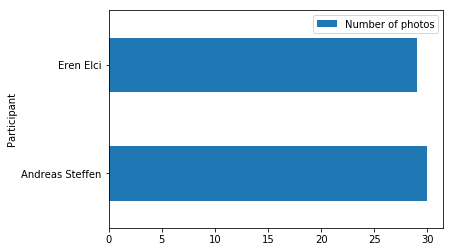

In [4]:
classes = [ name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name)) ]
nclasses = len(classes)
files = {cl:glob.glob(DATA_PATH+cl+"/*.jpg") for cl in classes}
df = pd.DataFrame(data={"Participant": [ f.replace("_", " ") for f in list(files.keys())], 
                   "Number of photos": [len(f) for f in files.values()] }).set_index("Participant")
df.plot(kind="barh");
#for cl,fls in files.items():
#    print("Category '{}' has {} images".format(cl,len(fls)))

## Split into the training and test sets and run face detection

It is important to validate your model on data it has not used as part of the tranining process. One way to do this is to split the data into *training* and *test* sets.  The model is purely trained on the *training* data and evaluated on "unseen" *test* data. This checks whether the model is able to generalise and probes the model for *overfitting*.

In [7]:
files_test = {}
files_train = {}
for cl in classes:
    files_train[cl], files_test[cl] = train_test_split(files[cl], test_size=5) # 2 pictures go into test set
    # create the train/test - directory structure and put the cropped pictures into it
train_dest_directory = DATA_PATH[:-1]+"_Train_Test/"
if not os.path.exists(train_dest_directory):
    os.makedirs(train_dest_directory)

## Run face detection on all photos in train and test set

In [8]:
froms = []
tos = []
for t_ in ["Train", "Test"]:
    for cl,fns in files_test.items() if t_ == "Test" else files_train.items():
        tmp_dir = train_dest_directory+t_+"/"+cl+"/"
        #print(tmp_dir)
        if not os.path.exists(tmp_dir):
            os.makedirs(tmp_dir)
        #for f in fns:
        for j in tqdm_notebook(range(len(fns)), desc='{}:'.format(cl.replace("_", " "))):
            f = fns[j]
            froms.append(f)
            tos.append(tmp_dir +f[f.rindex("/")+1:])
            convert_to_face_only(f, tmp_dir +f[f.rindex("/")+1:], final_height=FINAL_HEIGHT, final_width=FINAL_WIDTH) # runs face detection! 120x120 pictures
df = pd.DataFrame(data={"Input file": froms, "Target file": tos})
df.head()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

,Input file,Target file
0,/home/fisc/datascience/datascience_in_practice...,/home/fisc/datascience/datascience_in_practice...
1,/home/fisc/datascience/datascience_in_practice...,/home/fisc/datascience/datascience_in_practice...
2,/home/fisc/datascience/datascience_in_practice...,/home/fisc/datascience/datascience_in_practice...
3,/home/fisc/datascience/datascience_in_practice...,/home/fisc/datascience/datascience_in_practice...
4,/home/fisc/datascience/datascience_in_practice...,/home/fisc/datascience/datascience_in_practice...


## Build the deep learning model with Keras

We are going to implement an "standard" architecture to do the face recognition, which is illustrated in the figure below

![Typical CNN](typical_cnn.png)
Figure taken from "Hands-On Machine Learning with Scikit-Learn & TensorFlow"

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=( FINAL_HEIGHT, FINAL_WIDTH,3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.25)) #Dropout, acts as regularisation --> Fights overfitting

model.add(Dense(nclasses))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', #since we do multiclass classification
              optimizer='adam', #Adam Optimiser
              metrics=['accuracy']) # we use accuracy as a metric

## Illustration of data augmentation using Keras

### Try an experiment with the various parameters to get an intuition for their action

### Explanations

- **DATA_PATH**: Directory that contains images.
- **NUM_EXAMPLES**: Number of persons (classes) to use.
- **NUM_MUTATIONS_PER_PIC**: Number of random transformations per person.
- **ROTATION_RANGE**:  Integer degree range for random rotations
- **WIDTH_SHIFT_RANGE**: Float (fraction of total width). Range for random horizontal shifts.
- **HEIGHT_SHIFT_RANGE**: Float (fraction of total height). Range for random vertical shifts.
- **SHEAR_RANGE**: Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
- **ZOOM_RANGE**:  Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
- **HORIZONTAL_FLIP**: Whether or not to flip (mirror) the images w.r.t. to a vertical axis (Randomly flip inputs horizontally).
- **SEED**: Seed for the utilised pseudo-random number generator.

In [35]:
def draw_random_pic_matrix(DATA_PATH, NUM_EXAMPLES, NUM_MUTATIONS_PER_PIC,
                           ROTATION_RANGE=40, 
                           WIDTH_SHIFT_RANGE=0.2,
                           HEIGHT_SHIFT_RANGE=0.2,
                           SHEAR_RANGE=0.2,
                           ZOOM_RANGE=0.2,
                           HORIZONTAL_FLIP=True,
                           seed=None):
    if seed is not None:
        np.random.seed(seed)
    classes = [ name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name)) ]
    nclasses = len(classes)
    files = {cl:glob.glob(DATA_PATH+cl+"/*.jpg") for cl in classes}
    np.random.shuffle(classes)
    random_choices = [files[c][np.random.randint(0,len(files[c]),size=1)[0]] for c in classes[:NUM_EXAMPLES]]  
    
    datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    fill_mode='nearest')
    fig, axs = plt.subplots(nrows=NUM_EXAMPLES, ncols=1+NUM_MUTATIONS_PER_PIC, figsize=(8,8))
    for i,f in enumerate(random_choices):
        axrow = axs[i]
        img = load_img(f)  # this is a PIL image
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
        ax = axrow[0]
        ax.imshow(img)
        ax.axis("off")
        j=0
        for batch in datagen.flow(x, batch_size=1):
            ax = axrow[1+j]
            ax.imshow(image.array_to_img(batch[0]))
            j+=1
            ax.axis("off")
            if j==NUM_MUTATIONS_PER_PIC:
                break
    plt.show()

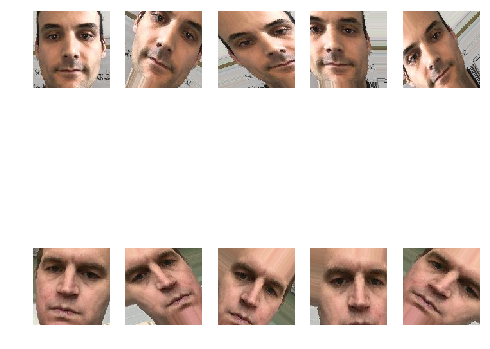

In [37]:
draw_random_pic_matrix(DATA_PATH=train_dest_directory+"Train/", 
                       NUM_EXAMPLES=2, 
                       NUM_MUTATIONS_PER_PIC=4,
                       ROTATION_RANGE=40, 
                       WIDTH_SHIFT_RANGE=0.2,
                       HEIGHT_SHIFT_RANGE=0.2,
                       SHEAR_RANGE=0.2,
                       ZOOM_RANGE=0.2,
                       HORIZONTAL_FLIP=True,
                       seed=42)

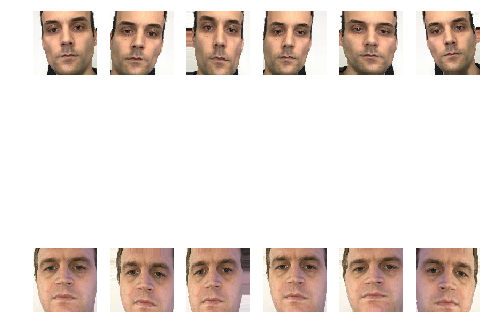

In [38]:
draw_random_pic_matrix(DATA_PATH=train_dest_directory+"Train/", 
                       NUM_EXAMPLES=2,  
                       NUM_MUTATIONS_PER_PIC=5,
                       ROTATION_RANGE=5, 
                       WIDTH_SHIFT_RANGE=0.1,
                       HEIGHT_SHIFT_RANGE=0.1,
                       SHEAR_RANGE=0.1,
                       ZOOM_RANGE=0.1,
                       HORIZONTAL_FLIP=True,
                       seed=43)

## Create Pipeline 

Back to our original goal...

As part of training we enrich (augment) the data by transformations. This is done to fight overfitting!

In [20]:
batch_size = 4 # should be around 8 if we have 30pics per person
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255, #normalisation
        rotation_range=5, #play around with this, was 5
        shear_range=0.1, #was 0.1
        zoom_range=0.1, #was 0.1
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
if AUGMENT_VALIDATION:
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=5, #play around with this
                                      shear_range=0.1,
                                      zoom_range=0.1,)
else:
    test_datagen = ImageDataGenerator(rescale=1./255)
# this is a generator that will read pictures found in
# subfolers of  train_dest_directory+'Train/', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dest_directory+'Train/',  # this is the target directory
        target_size=(FINAL_HEIGHT, FINAL_WIDTH),  # in case we want to resize images
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
                              

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
       train_dest_directory+'Test/',
        target_size=(FINAL_HEIGHT, FINAL_WIDTH),
        batch_size=batch_size,
        class_mode='categorical')

Found 58 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


## Start the fitting (learning)

In [24]:
NIMAGES_IN_TRAIN = np.sum([len(f) for f in files_train.values()])
NIMAGES_IN_TEST = np.sum([len(f) for f in files_test.values()])
history = model.fit_generator(
        train_generator,
        steps_per_epoch=50, #since we use data augmentation all will be distinct 
        epochs=20, #was 50
        validation_data=validation_generator,
        validation_steps=NIMAGES_IN_TEST if not AUGMENT_VALIDATION else 10*NIMAGES_IN_TEST  ) #was 800

Epoch 1/20
50/50 [==============================] - 2s - loss: 0.0463 - acc: 0.9900 - val_loss: 0.0166 - val_acc: 1.0000
Epoch 2/20
50/50 [==============================] - 2s - loss: 0.0197 - acc: 0.9900 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 3/20
50/50 [==============================] - 2s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4/20
50/50 [==============================] - 2s - loss: 0.0121 - acc: 0.9950 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 5/20
50/50 [==============================] - 2s - loss: 0.0038 - acc: 1.0000 - val_loss: 5.8759e-04 - val_acc: 1.0000
Epoch 6/20
50/50 [==============================] - 2s - loss: 0.0063 - acc: 1.0000 - val_loss: 5.2480e-04 - val_acc: 1.0000
Epoch 7/20
50/50 [==============================] - 2s - loss: 0.0032 - acc: 1.0000 - val_loss: 7.9607e-04 - val_acc: 1.0000
Epoch 8/20
50/50 [==============================] - 2s - loss: 0.0339 - acc: 0.9800 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 9/20
50/50 [==

In [25]:
model.save(MODEL_FILENAME)  
# Allows us to resolve Keras internal class labels (back to folder names used in the App)
class_dictionary = train_generator.class_indices
ids_to_classes = [k for (k,v) in class_dictionary.items()]
with open(MODEL_FILENAME.replace("h5", "pickle"), 'wb') as handle:
    pickle.dump(ids_to_classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Inspect the training process

### Loss vs epochs on training and test set (the smaller the better)

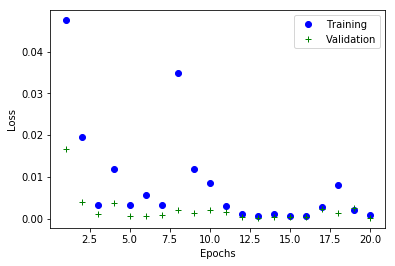

In [26]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
fig,ax = plt.subplots()
# "bo" is for "blue dot"
ax.plot(epochs, loss_values, 'bo',label="Training")
# g+ is for "green crosses"
ax.plot(epochs, val_loss_values, 'g+',label="Validation")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc="best")
plt.show()

### Accuracy vs epochs on training and test set (the higher the better)

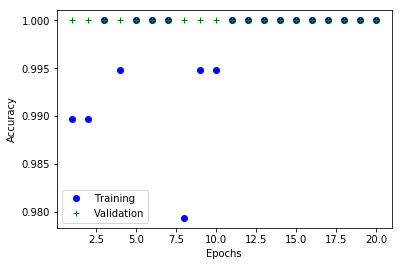

In [27]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)
# "bo" is for "blue dot"
fig, ax = plt.subplots()
ax.plot(epochs, acc_values, 'bo', label="Training")
# b+ is for "green crosses"
ax.plot(epochs, val_acc_values, 'g+', label="Validation")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc="best")
plt.show()

In [28]:
ls

dry_run_people_downscaled_0p5.py  model_TeamAndreasEren.pickle
dry_run_people_model_0p3.h5       new_pics/
dry_run_people_model_0p3.pickle   new_pics_Train_Test/
face_detection.py                 Predict.ipynb
face recognition.ipynb            predict_label.py
ImageAugmentationExample.ipynb    __pycache__/
images_RATIO_0p3/                 Rescaling.ipynb
images_RATIO_0p3_Train_Test/      Training.ipynb
images_RATIO_0p5/                 try_run_people_model_2.h5
images_RATIO_0p5_Train_Test/      try_run_people_model_2.pickle
img/                              try_run_people_model_3.h5
img_Train_Test/                   try_run_people_model_3.pickle
lfw_people_model_2.h5             try_run_people_model.h5
lfw_people_model_2.pickle         try_run_people_model.pickle
model_Group_1.h5                  typical_cnn.png
model_Group_1.pickle              Untitled.ipynb
model_TeamAndreasEren.h5


In [29]:
pwd

'/home/fisc/datascience/datascience_in_practice/whoisu/notebooks'